### Exploratory data analysis

In [1]:
import pickle
from train_test_split import get_training_portion_of_the_data
import pandas as pd
import numpy as np

# import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import calmap
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from model_evaluation import draw_word_cloud

%matplotlib inline

CATEGORY_COLUMN_NAME = "category"

Tarjoaa funktiot:
- testDifferentClassifiers(X_train, X_test, y_train, y_test, modelsToTest, average_type='binary')
- print_scoretable(scores, columns=['Accuracy', 'AUC', 'MCC', 'Precision', 'Recall'])  tulostaa DataFramen tyyliteltynä niin, että tekstin taustalla on palkit 
- draw_confusion_matrix_for_good_poor(truevalues, predictions, normalize=True, title=)  piirtää confusionmatrixin oletuksella, että 1/true = good, 0/false = poor
- drawWordCloud(words, title, numberofWords = 100, color='blue', titlefontsize=12)   värivaihtoehdot red, green, blue
- draw_roc_curve(fpr, tpr)  piirtää ROC-kuvaajan perustuen sklearn.metrics.roc_curve -funktion tuloksiin
- plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))


### Getting data from pickle files dumped in notebook 1

In [2]:
with open("random_reviews.p","rb") as f:
    random_reviews = pickle.load( f )

with open("bow1000.p","rb") as f:
    bow1000 = pickle.load( f )

In [3]:
# Obtaining train set as requested in project brief - 800 first lines as the training set
random_reviews_EDA = get_training_portion_of_the_data(random_reviews)
bow1000_EDA = get_training_portion_of_the_data(bow1000) 

returns 800 lines in total 1000 out of lines (portion 0.8)
returns 800 lines in total 1000 out of lines (portion 0.8)


## Visualizing review date distribution with calender heatmap

(<Figure size 1296x1440 with 14 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002AEF74EC080>,
       dtype=object))

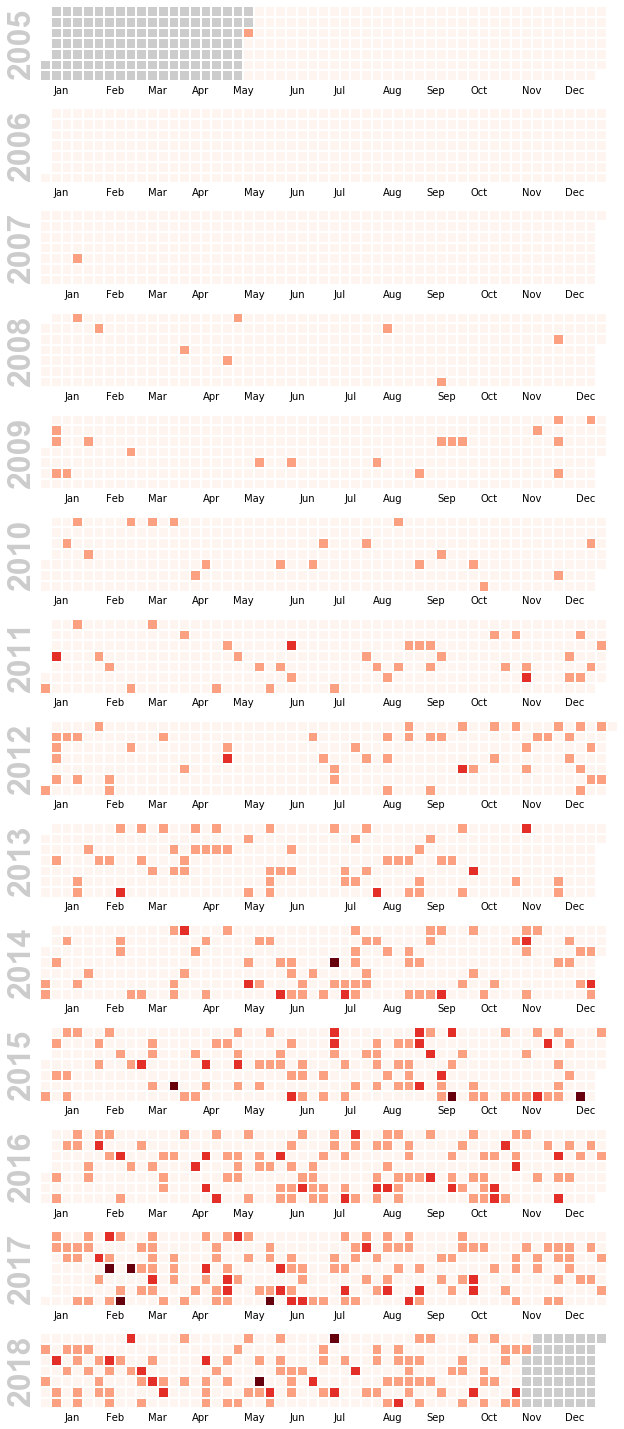

In [4]:
tempDf = pd.DataFrame()
tempDf['datetime'] = pd.to_datetime(random_reviews_EDA["date"])
tempDf.index = tempDf['datetime']
# A column of ones to tempDf
tempDf['count'] = np.ones(len(tempDf))
# Aggregating to date level
tempDf = tempDf.resample('d').sum()
calmap.calendarplot(tempDf["count"], fig_kws=dict(figsize=(18, 20)), fillcolor='#cccccc',daylabels='')


### Visualize the distribution of the star ratings.
Is there a bias or an imbalance in the distribution?

- observations:
    - mostly 5-star reviews - reflects the phenomena that ratings turn into binary ratings to some extent

In [5]:
total_count = len(random_reviews_EDA[CATEGORY_COLUMN_NAME])
good = np.array(sum(random_reviews_EDA[CATEGORY_COLUMN_NAME]==1)/total_count)
poor = np.array(sum(random_reviews_EDA[CATEGORY_COLUMN_NAME]==0)/total_count)

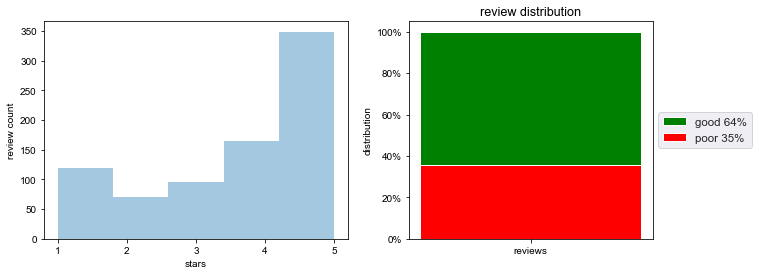

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 4))

# First generating histogram
ax1.set_ylabel("review count")
sns.distplot(random_reviews_EDA["stars"], bins = 5, ax= ax1, kde = False)

# Second generating stacked bar chart
sets = ['reviews']
ind = [x for x, _ in enumerate(sets)]
sns.set(font_scale=1.05)
plt.bar(ind, good, width=0.2, label='good {}%'.format(int(good*100)), color='green', bottom=poor)
plt.bar(ind, poor, width=0.2, label='poor {}%'.format(int(poor*100)), color='red')

plt.xticks(ind, sets)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

ax2.set_ylabel("distribution")
ax2.set_title("review distribution")

# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Generate the pairs plots and observe correlation between features and feature-labels.

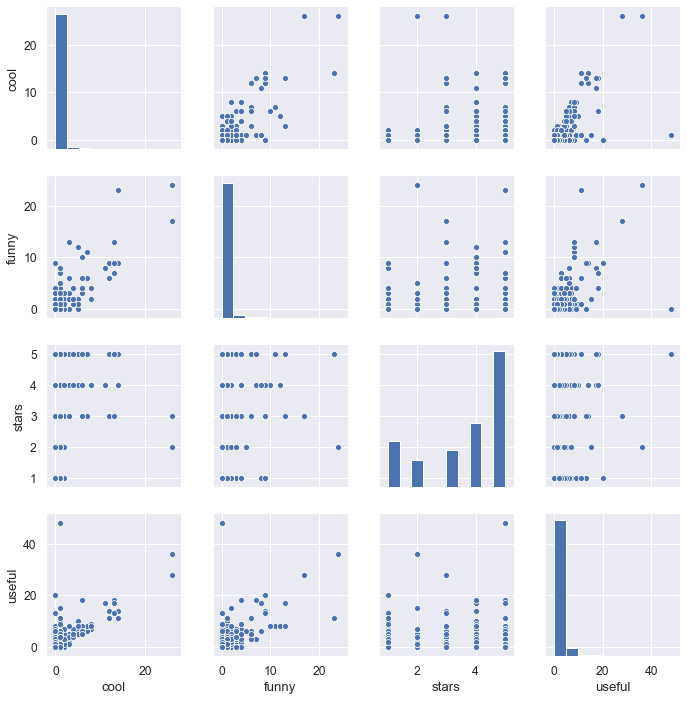

In [7]:
sns.set(font_scale=1.1)
g = sns.pairplot(random_reviews_EDA.drop("category", axis=1))

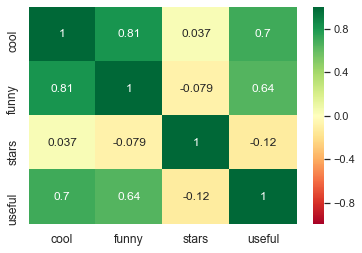

In [8]:
corr = random_reviews_EDA.drop("category", axis=1).corr()

f, ax = plt.subplots() #figsize=(9, 6)
sns.set(font_scale=1)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdYlGn', center=0, vmin=-1, vmax=1, annot=True, ax=ax)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.show()

## Unique businesses and reviewers in reviews
- observations:
    - mostly no repeated businesses and reviewers in reviews

Number of unique businesses 783


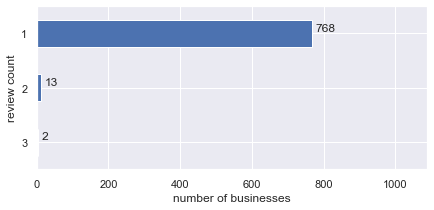

Number of unique users 799


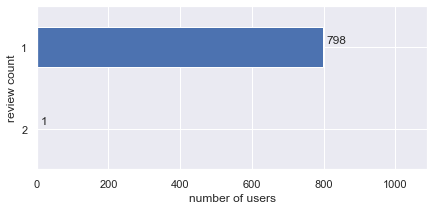

In [9]:
# First getting number of unique businesses
pivot1 = random_reviews_EDA.groupby('business_id')['date'].nunique().reset_index(name='review count')
pivot1.sort_values(ascending=False, by="review count")
print("Number of unique businesses {}".format(len(pivot1)))

# Visualizing the distribution of businesses
pivot2 = pivot1.groupby('review count')['business_id'].nunique().reset_index(name='number of businesses')
ax1 = pivot2.plot.barh(x='review count', y='number of businesses', legend=False, figsize=(7,3),)
ax1.set_xlabel("number of businesses")
for i, each in enumerate(pivot2.index):
    y = pivot2.iloc[each][1]
    ax1.text(y+10, i-0.05, y)
ax1.set_xlim(0,1090)
ax1.invert_yaxis()
plt.show()

# Number of unique users in reviews
random_reviews_EDA.index.name = 'id'
pivot1 = random_reviews_EDA.groupby('user_id')['date'].nunique().reset_index(name='review count')
pivot1.sort_values(ascending=False, by="review count")
print("Number of unique users {}".format(len(pivot1)))

# Visualising the distribution of users
pivot2 = pivot1.groupby('review count')['user_id'].nunique().reset_index(name='number of users')
ax2 = pivot2.plot.barh(x='review count', y='number of users',  legend=False, figsize=(7,3), ) # figsize=(7,3),
ax2.set_xlabel("number of users")
ax2.set_xlim(0,1090)
for i, each in enumerate(pivot2.index):
    y = pivot2.iloc[each][1]
    ax2.text(y+10, i-0.05, y)
ax2.invert_yaxis()
plt.show()

### Finding ten most common words
- observations:
    - words seem to be related to most important aspects of reviewing catering businesses and signal positivity (consistent with high degree of positive reviews) 

In [10]:
# Column sums for training and sorting - this done only on training set
column_sums = bow1000_EDA.sum(axis=0)
column_sums.sort_values(ascending=False)[:10]

place      375
good       375
food       363
great      354
time       318
service    311
get        309
one        275
like       268
back       234
dtype: int64

### Generate a “wordcloud" plot for 100 most frequent words of the selected

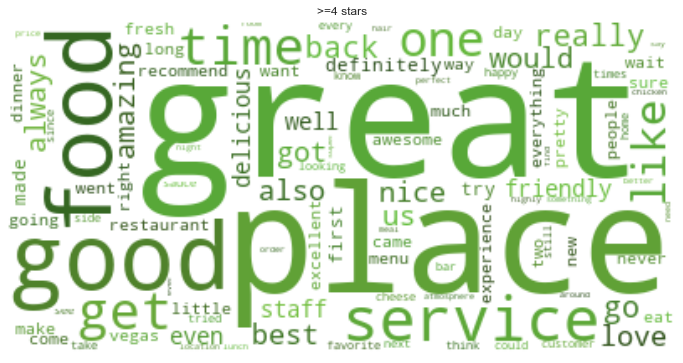

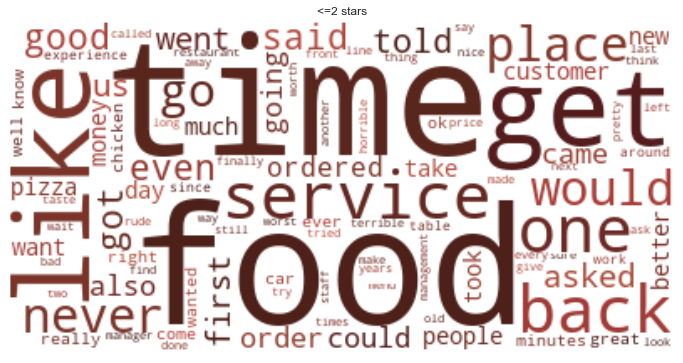

In [23]:
draw_word_cloud(bow1000_EDA.loc[random_reviews_EDA['stars'] >= 4], ">=4 stars", color="green")
draw_word_cloud(bow1000_EDA.loc[random_reviews_EDA['stars'] <= 2], "<=2 stars", color="red")

### Correlations between bag of words words, i.e. are some words correlated
- observations:
    - the large majority of words are not correlated, there may be some exceptions - as expected

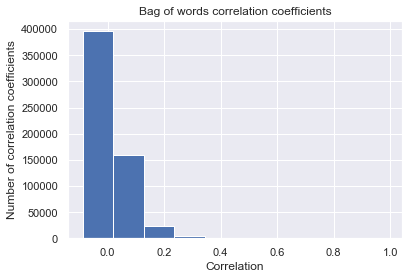

In [12]:
# Correlation matrix of shape 1080*1080 from BOW
corr = bow1000_EDA.corr()
corr = corr.to_numpy()
# Extracting only values above diagonal
corr = corr[np.triu_indices_from(corr, k=1)]

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Correlation')
ax.set_ylabel('Number of correlation coefficients')
ax.set_title('Bag of words correlation coefficients')
ax.hist(corr,bins=10)

plt.show()

### Class distributions for review usefulness
- most reviews have been marked useful only few times as expected

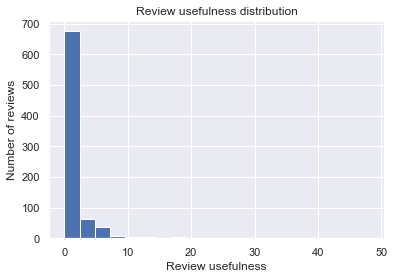

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Review usefulness')
ax.set_ylabel('Number of reviews')
ax.set_title('Review usefulness distribution')
ax.hist(random_reviews_EDA['useful'],bins=20)

plt.show()

### Correlation between good/bad and BoW
- observations:
    - majority of words are not strongly correlated with good/bad reviews categorization - as expected

In [14]:
correlations_good_bad_Bow = []
# Going through all words and obtaining correlation coefficient
for column in bow1000_EDA.columns:
  coef = np.corrcoef(x=random_reviews_EDA['category'],y=bow1000_EDA[column])[0,1]
  correlations_good_bad_Bow.append(coef)

In [15]:
np.array(correlations_good_bad_Bow).size

1080

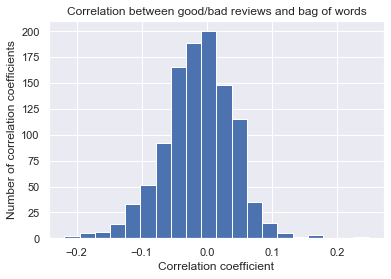

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Number of correlation coefficients')
ax.set_title('Correlation between good/bad reviews and bag of words')
ax.hist(correlations_good_bad_Bow,bins=20)

plt.show()

### Correlation between usefulness and BoW
- observations:
    - majority of words are not strongly correlated with usefulness of review - as expected 

In [17]:
correlations_usefulness_Bow = []
# Going through all words and obtaining correlation coefficient
for column in bow1000_EDA.columns:
  coef = np.corrcoef(x=random_reviews_EDA['useful'],y=bow1000_EDA[column])[0,1]
  correlations_usefulness_Bow.append(coef)

In [18]:
np.array(correlations_usefulness_Bow).size

1080

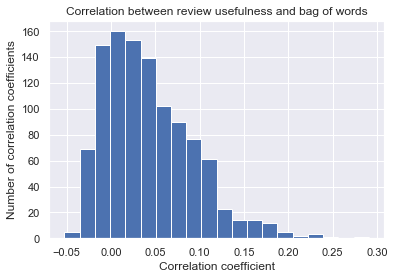

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('Number of correlation coefficients')
ax.set_title('Correlation between review usefulness and bag of words')
ax.hist(correlations_usefulness_Bow,bins=20)

plt.show()

### Use PCA for BoW1000.csv to plot the data as a two-dimensional scatter plot. Explain your plot. (need to go EDA notebook)

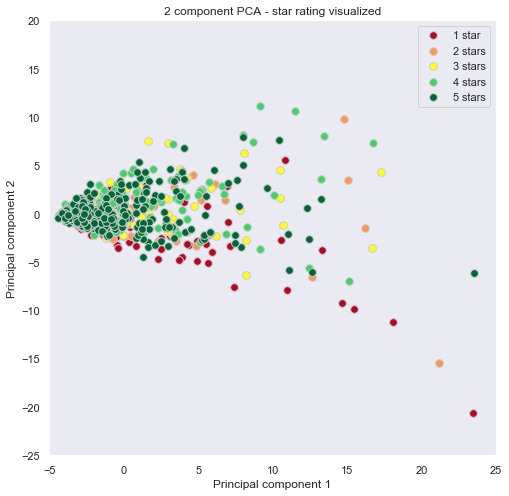

In [20]:
# PCA on the data and visualizing to 2D -
standardized_data = StandardScaler().fit_transform(bow1000_EDA)

pca = PCA()
principal_components = pca.fit_transform(standardized_data)
principalDF = pd.DataFrame(data = principal_components)

# Adding review column stars to principal df dataframe
principalDF["stars"] = random_reviews["stars"].head(800)

# Visualization
fig = plt.figure(figsize= (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
ax.set_title('2 component PCA - star rating visualized')

targets = [1,2,3,4,5]
legend_text = ["1 star", "2 stars", "3 stars","4 stars", "5 stars"]
colors = ['#AF0926','#FA9656','#FFFD17','#40D168','#006837']
for target, color in zip(targets,colors):
    indicesToKeep = principalDF['stars'] == target
    ax.scatter(principalDF.loc[indicesToKeep, 0]
               , principalDF.loc[indicesToKeep, 1]
               , c = color
              #  , alpha = 0.5
               , s = 60, edgecolors = "#cccccc")
ax.legend(legend_text)
ax.set_ylim(-25, 20)
ax.set_xlim(-5, 25)

#ax.scatter(principalDF[0],principalDF[1])

ax.grid()

### How many PCA components are need to reconstruct 50% of the original data?

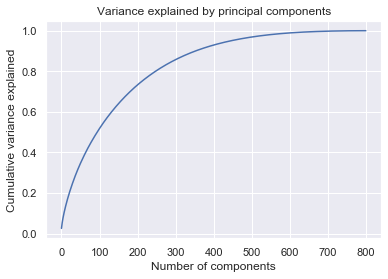

How many componenents to reconstruct 50%?  94  components


In [21]:

explained = pca.explained_variance_ratio_.cumsum()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative variance explained')
ax.set_title('Variance explained by principal components')
ax.plot(np.arange(len(explained)),explained)

plt.show()

# How many components to reach 50%?
print("How many componenents to reconstruct 50%? ", explained.size - explained[ explained > 0.50].size, " components")